In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os

from IPython.display import display
from PIL import Image

import streamlit as st

from bsoid_utils import adp_filt, compute, subsample

In [2]:
screenshots = r"screenshots" # where the screenshots are-- this can be an absolute or relative path
file_path = r"posedata/short_rat/20231130 _Front_ShortDLC_resnet50_RatFeb2shuffle1_1080000.csv" # pose data 

# LOAD DATA and PREPROCESS

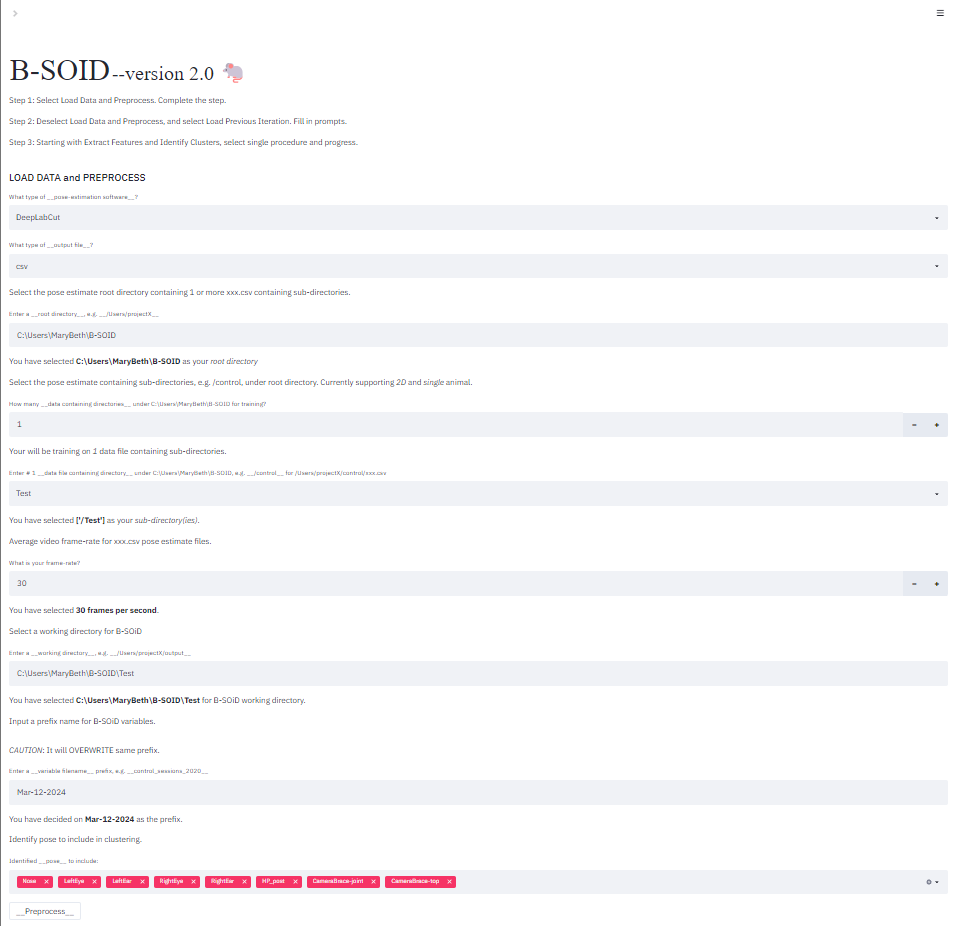

In [3]:
display(Image.open(os.path.join(screenshots, "LOAD_DATA_and_PREPROCESS.png")))

### Input frames per second

In [4]:
fps = 30                       

In [5]:
pose_chosen = []

file0_df = pd.read_csv(file_path, low_memory=False)
file0_array = np.array(file0_df)
p = st.multiselect('Identified __pose__ to include:', [*file0_array[0, 1:-1:3]], [*file0_array[0, 1:-1:3]])
for a in p:
    index = [i for i, s in enumerate(file0_array[0, 1:]) if a in s]
    if not index in pose_chosen:
        pose_chosen += index
pose_chosen.sort()
print(pose_chosen)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [6]:
file_j_df = pd.read_csv(file_path, low_memory=False)
file_j_processed, p_sub_threshold = adp_filt(file_j_df, pose_chosen)
print(file_j_processed.shape)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 35.62it/s]

(2886, 16)


# LOAD PREVIOUS ITERATION

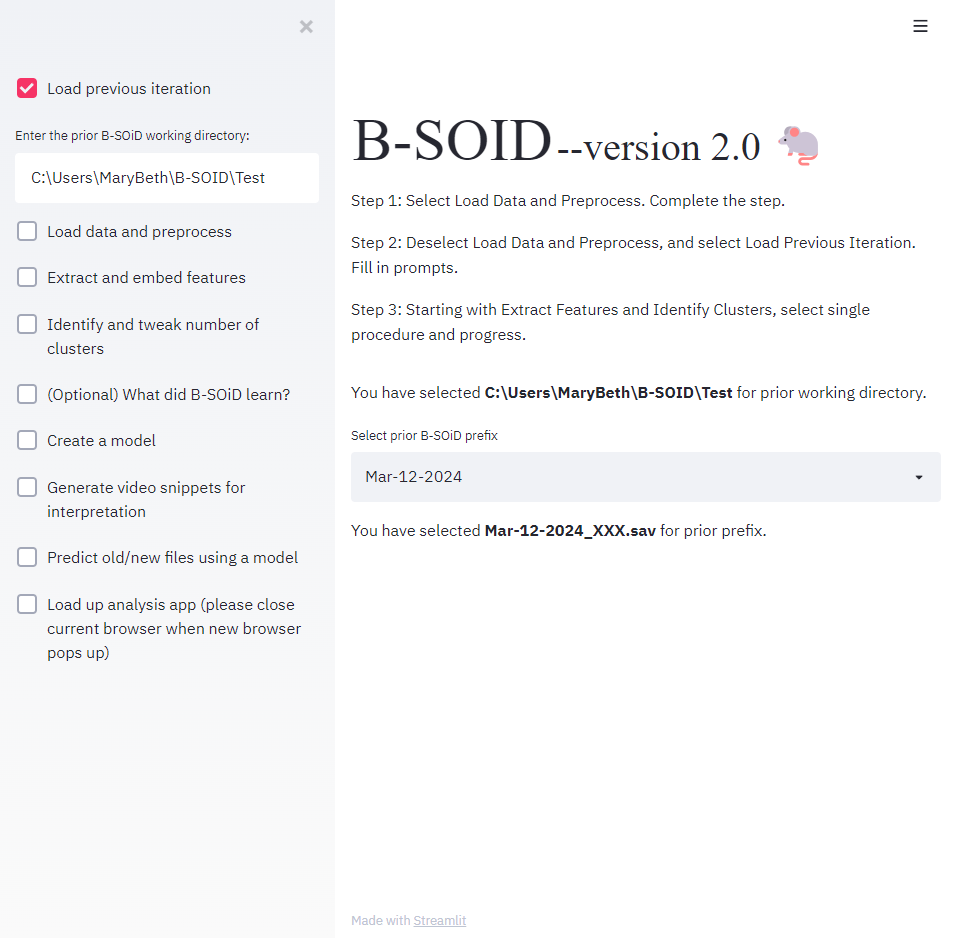

In [7]:
display(Image.open(os.path.join(screenshots, "LOAD_PREVIOUS_ITERATION.png")))

# EXTRACT AND EMBED FEATURES

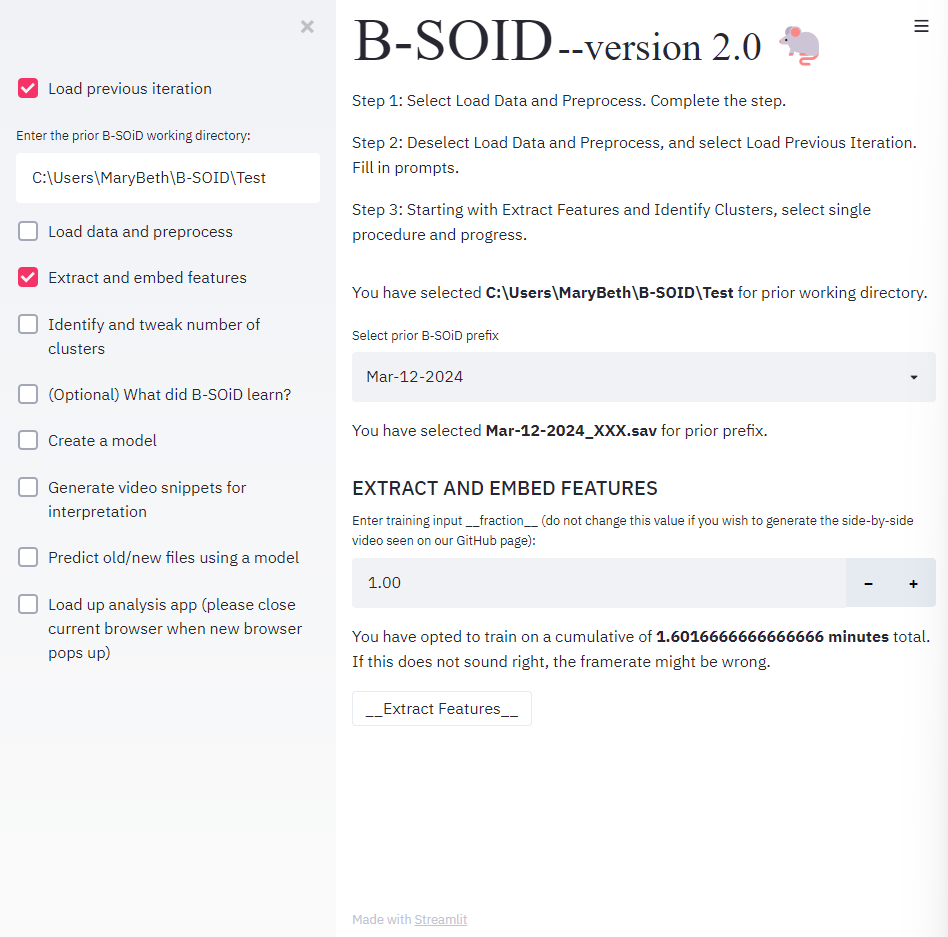

In [8]:
display(Image.open(os.path.join(screenshots, "EXTRACT_and_EMBED_FEATURES.png")))

In [9]:
# reshape for compute 
file_j_processed = file_j_processed.reshape((1, file_j_processed.shape[0], file_j_processed.shape[1]))

scaled_features, features = compute(file_j_processed, fps)

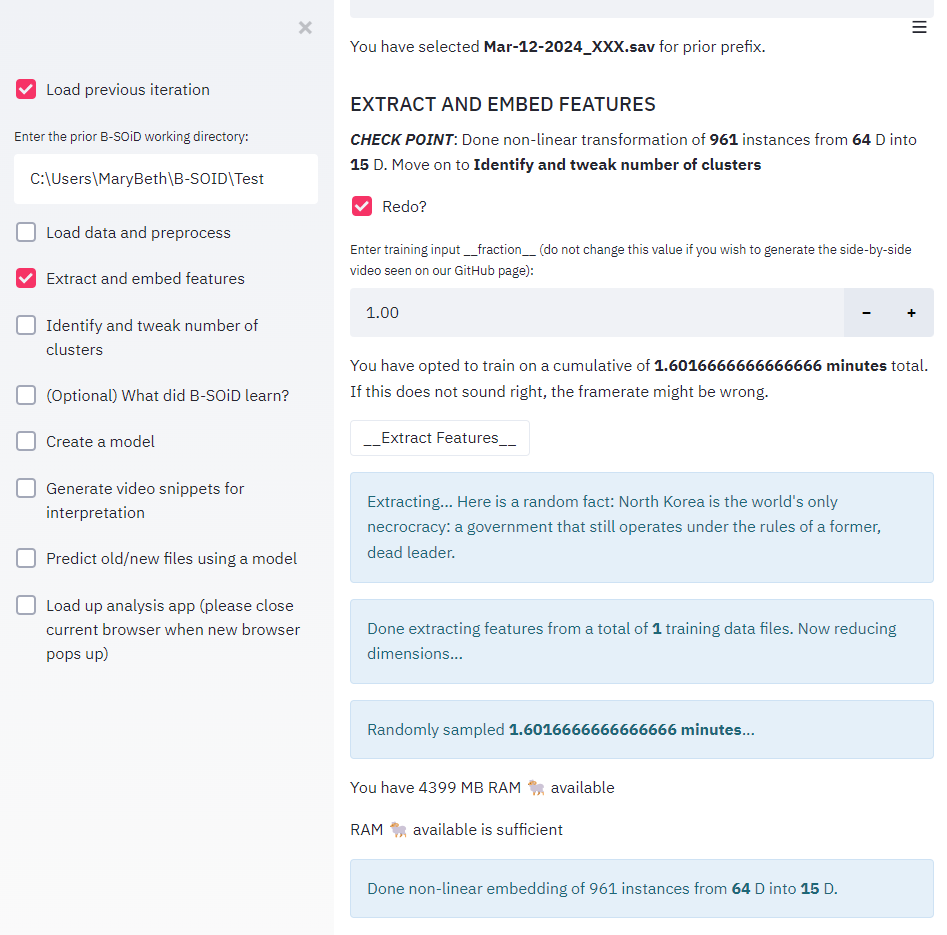

In [10]:
display(Image.open(os.path.join(screenshots, "EXTRACT_and_EMBED_FEATURES_2.png")))

In [11]:
train_size = subsample(file_j_processed, fps)

In [12]:
from sklearn.decomposition import PCA
import umap

# bsoid_umap/config/GLOBAL_CONFIG.py # edited 
UMAP_PARAMS = {
    'min_dist': 0.0,  # small value
    'random_state': 42,
}

In [13]:
# bsoid_app/extract_features.py # edited
input_feats = scaled_features.T

print("Original dimensions: ", np.shape(input_feats))

pca = PCA()
pca.fit(scaled_features.T)
num_dimensions = np.argwhere(np.cumsum(pca.explained_variance_ratio_) >= 0.7)[0][0] + 1
if train_size > input_feats.shape[0]:
    train_size = input_feats.shape[0]
np.random.seed(0)
sampled_input_feats = input_feats[np.random.choice(input_feats.shape[0], train_size, replace=False)]
features_transposed = features.T
np.random.seed(0)
sampled_features = features_transposed[np.random.choice(features_transposed.shape[0],
                                                                     train_size, replace=False)]

learned_embeddings = umap.UMAP(n_neighbors=60, n_components=num_dimensions,
                                               **UMAP_PARAMS).fit(sampled_input_feats)

sampled_embeddings = learned_embeddings.embedding_

print("Embedding dimensions: ", np.shape(sampled_embeddings))

Original dimensions:  (961, 64)
Embedding dimensions:  (961, 15)


# IDENTIFY AND TWEAK NUMBER OF CLUSTERS

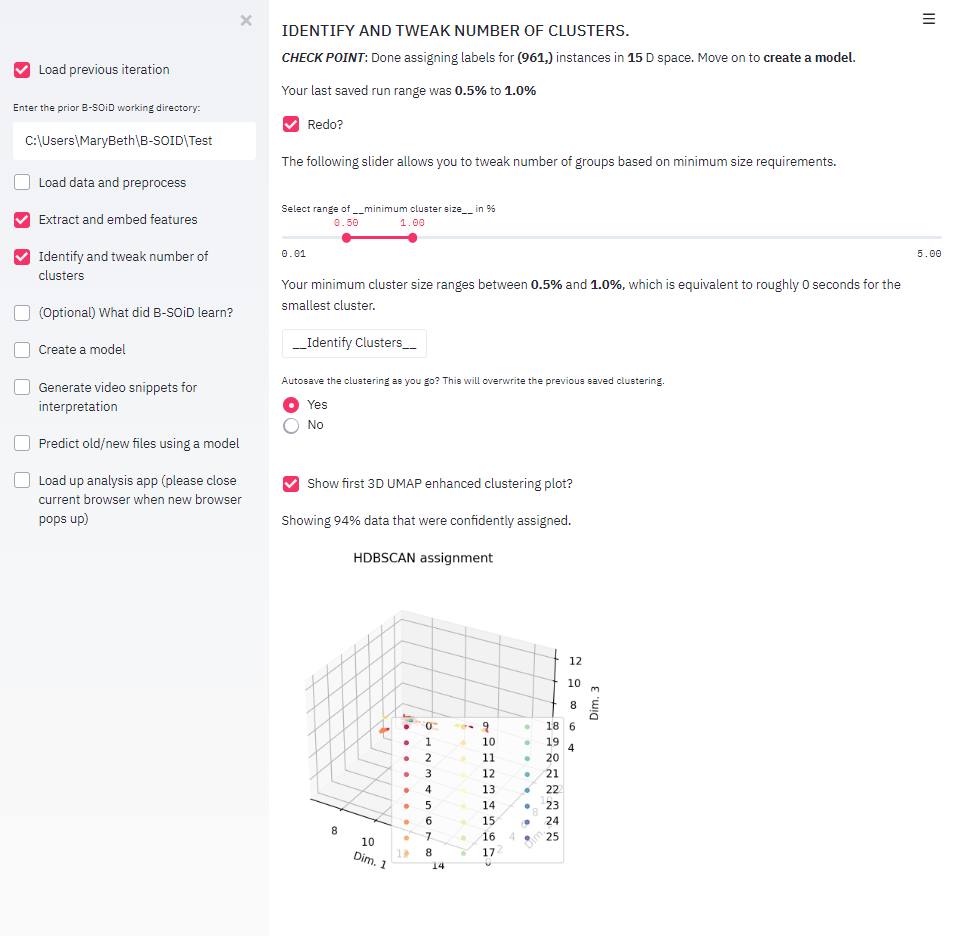

In [14]:
display(Image.open(os.path.join(screenshots, "IDENTIFY_and_TWEAK_NUMBER_of_CLUSTERS.png")))

### Input minimum cluster size

In [15]:
cluster_range = [0.5, 1]

In [16]:
import hdbscan

# bsoid_umap/config/GLOBAL_CONFIG.py
# HDBSCAN params, density based clustering
HDBSCAN_PARAMS = {
    'min_samples': 1  # small value
}

In [17]:
# bsoid_app/clustering.py # edited 
max_num_clusters = -np.infty
num_clusters = []
min_cluster_size = np.linspace(cluster_range[0], cluster_range[1], 25)

for min_c in min_cluster_size:
    learned_hierarchy = hdbscan.HDBSCAN(
        prediction_data=True, min_cluster_size=int(round(min_c * 0.01 * sampled_embeddings.shape[0])),
        **HDBSCAN_PARAMS).fit(sampled_embeddings)
    num_clusters.append(len(np.unique(learned_hierarchy.labels_)))
    if num_clusters[-1] > max_num_clusters:
        max_num_clusters = num_clusters[-1]
        retained_hierarchy = learned_hierarchy
assignments = retained_hierarchy.labels_
assign_prob = hdbscan.all_points_membership_vectors(retained_hierarchy)
soft_assignments = np.argmax(assign_prob, axis=1)

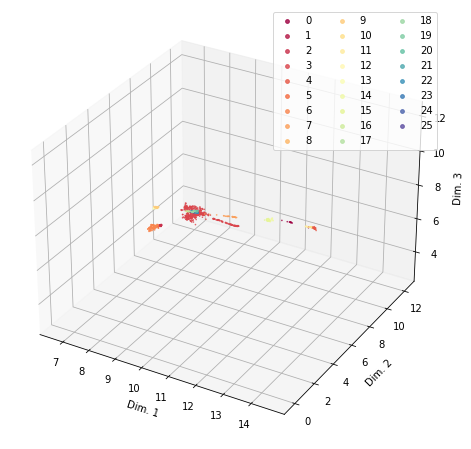

In [18]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

sampled_embeddings_filtered = sampled_embeddings[assignments>=0]
assignments_filtered = assignments[assignments>=0]

# bsoid_app/bsoid_utilities/visuals.py
#def plot_classes(data, assignments):
#   """ Plot umap_embeddings for HDBSCAN assignments
#    :param data: 2D array, umap_embeddings
#    :param assignments: 1D array, HDBSCAN assignments
#    """
uk = list(np.unique(assignments_filtered))
R = np.linspace(0, 1, len(uk))
cmap = plt.cm.get_cmap("Spectral")(R)
umap_x, umap_y, umap_z = sampled_embeddings_filtered[:, 0], sampled_embeddings_filtered[:, 1], sampled_embeddings_filtered[:, 2]
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
for g in np.unique(assignments_filtered):
    idx = np.where(np.array(assignments_filtered) == g)
    ax.scatter(umap_x[idx], umap_y[idx], umap_z[idx], c=cmap[g],
                label=g, s=0.4, marker='o', alpha=0.8)
ax.set_xlabel('Dim. 1')
ax.set_ylabel('Dim. 2')
ax.set_zlabel('Dim. 3')
plt.legend(ncol=3, markerscale=6)

In [20]:
print(type(fig))

<class 'matplotlib.figure.Figure'>
